In [1]:
!pip install pyspark

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [3]:
spark = (
    SparkSession.builder
    .appName("Churn-Analysis")
    .master("local[*]")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

In [4]:
cd /content/drive/MyDrive/Talk_talk

/content/drive/.shortcut-targets-by-id/1Hc6JNdQGWtt7ZkVjQux9MMEg17i44ZOm/Talk_talk


In [5]:
usage_df = spark.read.option("inferSchema", "true")\
            .parquet("/content/drive/MyDrive/Talk_talk/usage.parquet")

customer_info_df = spark.read.option("inferSchema", "true") \
            .parquet("/content/drive/MyDrive/Talk_talk/customer_info.parquet")

cease_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/content/drive/MyDrive/Talk_talk/cease.csv")

call_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/content/drive/MyDrive/Talk_talk/calls.csv")

In [6]:
usage_df.printSchema()
customer_info_df.printSchema()
cease_df.printSchema()
call_df.printSchema()

root
 |-- unique_customer_identifier: string (nullable = true)
 |-- calendar_date: date (nullable = true)
 |-- usage_download_mbs: string (nullable = true)
 |-- usage_upload_mbs: string (nullable = true)

root
 |-- unique_customer_identifier: string (nullable = true)
 |-- datevalue: date (nullable = true)
 |-- contract_status: string (nullable = true)
 |-- contract_dd_cancels: long (nullable = true)
 |-- dd_cancel_60_day: integer (nullable = true)
 |-- ooc_days: integer (nullable = true)
 |-- technology: string (nullable = true)
 |-- speed: integer (nullable = true)
 |-- line_speed: double (nullable = true)
 |-- sales_channel: string (nullable = true)
 |-- crm_package_name: string (nullable = true)
 |-- tenure_days: integer (nullable = true)

root
 |-- unique_customer_identifier: string (nullable = true)
 |-- cease_placed_date: date (nullable = true)
 |-- cease_completed_date: string (nullable = true)
 |-- reason_description: string (nullable = true)
 |-- reason_description_insight: st

# **Who is Leaving?**

**Churn rate across our customer base**

In [8]:
total_count = customer_info_df.agg(
    F.countDistinct("unique_customer_identifier")
).collect()[0][0]

churned_count = cease_df.filter(
    F.col("cease_completed_date") != 'null'
).agg(F.countDistinct("unique_customer_identifier")).collect()[0][0]

churn_rate = churned_count / total_count

print(f"Number of Customers: {total_count}")
print(f"Churned Count of Customers: {churned_count}")
print(f"Overall Churn Rate: {round(churn_rate * 100, 2)}%")

Number of Customers: 202782
Churned Count of Customers: 117559
Overall Churn Rate: 57.97%


**Reason-wise churn % (share of churned customers by reason)**

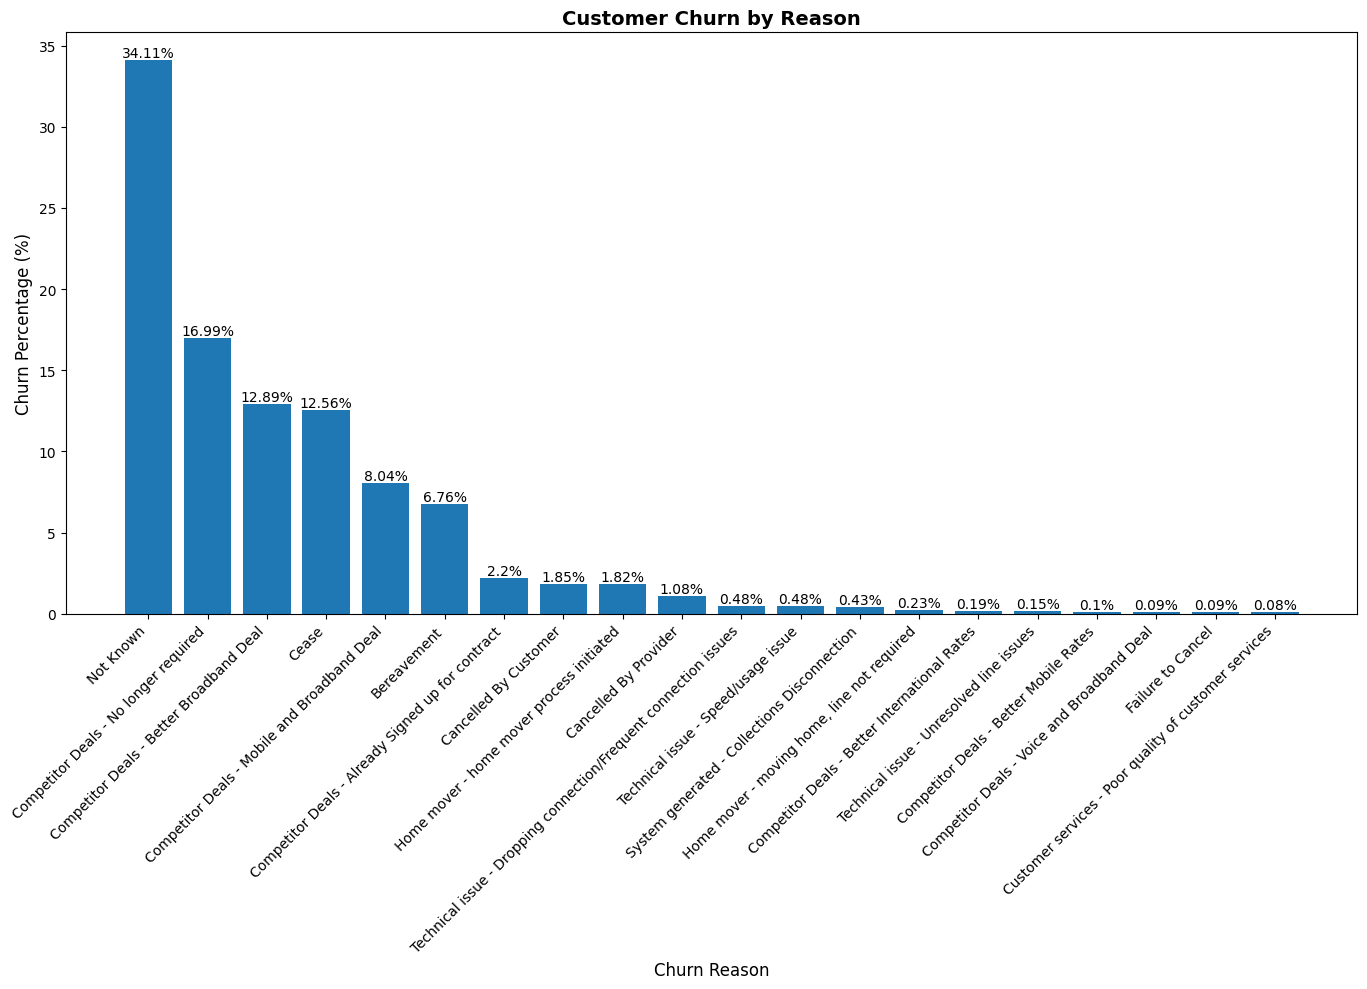

In [9]:
churned_by_reason = cease_df.filter(F.col("cease_completed_date")!= 'null')

reason_counts = churned_by_reason.groupBy("reason_description") \
    .agg(F.countDistinct("unique_customer_identifier").alias("churned_customers"))


total_churned = churned_by_reason.select("unique_customer_identifier").distinct().count()

reason_churn_share = reason_counts \
    .withColumn("churn_percentage", F.round((F.col("churned_customers") / total_churned) * 100, 2)) \
    .orderBy(F.col("churn_percentage").desc())

reason_churn_pd = reason_churn_share.limit(20).toPandas()

plt.figure(figsize=(14, 10))
bars = plt.bar(reason_churn_pd['reason_description'], reason_churn_pd['churn_percentage'])

plt.xlabel('Churn Reason', fontsize=12)
plt.ylabel('Churn Percentage (%)', fontsize=12)
plt.title('Customer Churn by Reason', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Reason description-wise churn % (share of churned customers by reason)**

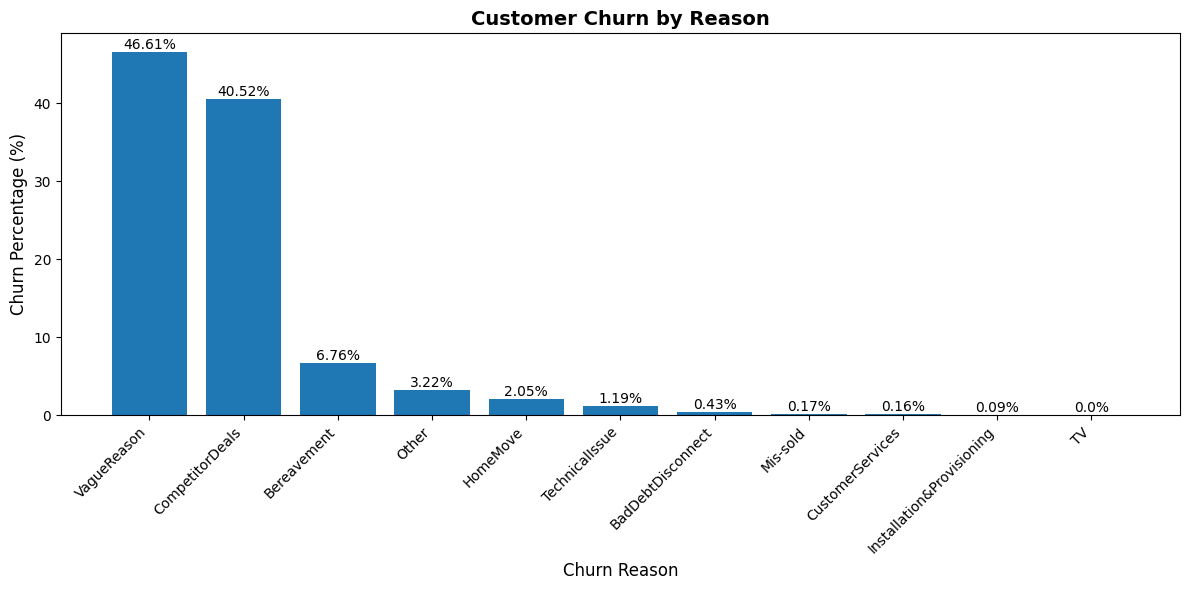

In [10]:
churned_by_reason = cease_df.filter(F.col("cease_completed_date")!= 'null')

reason_counts = churned_by_reason.groupBy("reason_description_insight") \
    .agg(F.countDistinct("unique_customer_identifier").alias("churned_customers"))


total_churned = churned_by_reason.select("unique_customer_identifier").distinct().count()

reason_churn_share = reason_counts \
    .withColumn("churn_percentage", F.round((F.col("churned_customers") / total_churned) * 100, 2)) \
    .orderBy(F.col("churn_percentage").desc())

reason_churn_pd = reason_churn_share.limit(20).toPandas()

plt.figure(figsize=(12, 6))
bars = plt.bar(reason_churn_pd['reason_description_insight'], reason_churn_pd['churn_percentage'])

plt.xlabel('Churn Reason', fontsize=12)
plt.ylabel('Churn Percentage (%)', fontsize=12)
plt.title('Customer Churn by Reason', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [11]:
cease_customer_profiles = customer_info_df.join(
    cease_df,
    on="unique_customer_identifier",
    how="inner"
)

**Sales channel has the highest churn rate**

In [12]:
w = Window.partitionBy("unique_customer_identifier").orderBy(F.col("datevalue").desc())

cust_latest = customer_info_df \
    .withColumn("rn", F.row_number().over(w)) \
    .filter(F.col("rn") == 1) \
    .select("unique_customer_identifier", "sales_channel")

churned = cease_df.filter(F.col("cease_completed_date")!='null') \
    .select("unique_customer_identifier").distinct()

churned_with_channel = churned.join(cust_latest, on="unique_customer_identifier", how="left")

counts = churned_with_channel.groupBy("sales_channel").agg(
    F.countDistinct("unique_customer_identifier").alias("churned_customers")
)

total_churned = churned.count()

share = counts.withColumn(
    "churn_share_pct",
    F.round(F.col("churned_customers") / F.lit(total_churned) * 100, 2)
).orderBy(F.col("churn_share_pct").desc())

share.show(200, truncate=False)

+------------------+-----------------+---------------+
|sales_channel     |churned_customers|churn_share_pct|
+------------------+-----------------+---------------+
|Online - Affiliate|40425            |34.39          |
|Partners          |14569            |12.39          |
|Inbound           |14406            |12.25          |
|Online - Search   |11006            |9.36           |
|Unknown           |9038             |7.69           |
|Migrated Customer |8029             |6.83           |
|Retail            |7458             |6.34           |
|Online - Ambient  |6973             |5.93           |
|Webchat           |3140             |2.67           |
|Field             |1021             |0.87           |
|Online - Other    |885              |0.75           |
|Outbound          |546              |0.46           |
|Other             |63               |0.05           |
+------------------+-----------------+---------------+



**Which package has the highest churn concentration**

In [13]:
churned_customers = cease_df.filter(F.col("cease_completed_date")!='null') \
    .select("unique_customer_identifier").distinct()

churned_pkg_ever = churned_customers.join(
    customer_info_df.select("unique_customer_identifier", "crm_package_name").distinct(),
    on="unique_customer_identifier",
    how="left"
).withColumn("crm_package_name", F.coalesce(F.col("crm_package_name"), F.lit("Unknown"))) \
 .dropDuplicates(["unique_customer_identifier", "crm_package_name"])

pkg_ever_counts = churned_pkg_ever.groupBy("crm_package_name").agg(
    F.countDistinct("unique_customer_identifier").alias("churned_customers_who_ever_had_pkg")
)

total_churned = churned_customers.count()

pkg_ever_share = pkg_ever_counts.withColumn(
    "pct_of_churners_who_ever_had_pkg",
    F.round(F.col("churned_customers_who_ever_had_pkg") / F.lit(total_churned) * 100, 2)
).orderBy(F.col("pct_of_churners_who_ever_had_pkg").desc())

pkg_ever_share.show(50, truncate=False)

+----------------------------------------------+----------------------------------+--------------------------------+
|crm_package_name                              |churned_customers_who_ever_had_pkg|pct_of_churners_who_ever_had_pkg|
+----------------------------------------------+----------------------------------+--------------------------------+
|Fibre 65 (FTTC-OR)                            |63556                             |54.06                           |
|Fibre 35 (FTTC-OR)                            |26044                             |22.15                           |
|Faster Fibre                                  |13394                             |11.39                           |
|Fast Broadband                                |11420                             |9.71                            |
|Fibre 150 (GFast-OR)                          |5569                              |4.74                            |
|Ultra Fibre Optic                             |361             

In [14]:
churned_ids = cease_df \
    .filter(F.col("cease_completed_date")!='null') \
    .select("unique_customer_identifier") \
    .distinct()

cust = customer_info_df \
    .select(
        "unique_customer_identifier",
        "datevalue",
        "crm_package_name",
        "technology",
        "speed",
        "sales_channel",
        "ooc_days",
        "contract_status",
        "tenure_days"
    )

churned_hist = churned_ids.join(cust, on="unique_customer_identifier", how="inner")

pkg_steps = churned_hist \
    .withColumn("prev_package", F.lag("crm_package_name").over(w)) \
    .withColumn("prev_date", F.lag("datevalue").over(w)) \
    .withColumn("changed", F.when(
        (F.col("prev_package").isNotNull()) & (F.col("crm_package_name") != F.col("prev_package")),
        F.lit(1)
    ).otherwise(F.lit(0)))

pkg_transitions = pkg_steps.filter(F.col("changed") == 1) \
    .select(
        "unique_customer_identifier",
        F.col("prev_package").alias("from_package"),
        F.col("crm_package_name").alias("to_package"),
        "prev_date",
        "datevalue"
    )

transition_counts = pkg_transitions.groupBy("from_package", "to_package").agg(
    F.count("*").alias("transition_events"),
    F.countDistinct("unique_customer_identifier").alias("unique_customers")
)

total_events = transition_counts.agg(F.sum("transition_events").alias("tot")).collect()[0]["tot"]

transition_share = transition_counts.withColumn(
    "event_share_pct",
    F.round(F.col("transition_events") / F.lit(total_events) * 100, 2)
).orderBy(F.col("transition_events").desc())

transition_share.show(50, truncate=False)

+------------------------+----------------------------------------+-----------------+----------------+---------------+
|from_package            |to_package                              |transition_events|unique_customers|event_share_pct|
+------------------------+----------------------------------------+-----------------+----------------+---------------+
|Fast Broadband          |Fibre 65 (FTTC-OR)                      |1238             |1238            |24.54          |
|Fibre 65 (FTTC-OR)      |Fibre 35 (FTTC-OR)                      |1122             |1122            |22.24          |
|Fibre 65 (FTTC-OR)      |Faster Fibre                            |803              |803             |15.92          |
|Fast Broadband          |Fibre 35 (FTTC-OR)                      |498              |497             |9.87           |
|Fibre 35 (FTTC-OR)      |Faster Fibre                            |330              |330             |6.54           |
|Fibre 65 (FTTC-OR)      |Fast Broadband        

**Are longer-tenured customers more loyal than newer customers?**

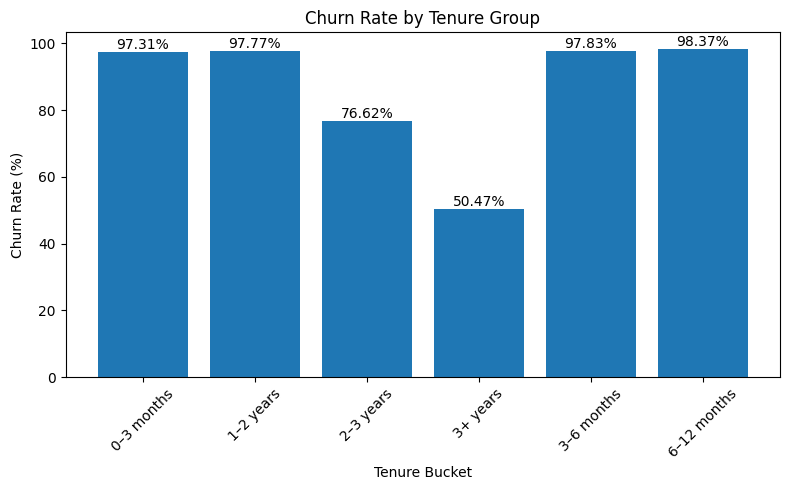

In [15]:
churned_ids = cease_df.filter(F.col("cease_completed_date").isNotNull()) \
    .select("unique_customer_identifier").distinct() \
    .withColumn("is_churned", F.lit(1))

w = Window.partitionBy("unique_customer_identifier").orderBy(F.col("datevalue").desc())


cust_latest = customer_info_df \
    .withColumn("rn", F.row_number().over(w)) \
    .filter(F.col("rn") == 1) \
    .select("unique_customer_identifier", "tenure_days")

base_cust = cust_latest.join(churned_ids, on="unique_customer_identifier", how="left") \
    .withColumn("is_churned", F.coalesce(F.col("is_churned"), F.lit(0)))

tenure_banded = base_cust.withColumn(
    "tenure_bucket",
    F.when(F.col("tenure_days") < 90,  "0–3 months")
     .when(F.col("tenure_days") < 180, "3–6 months")
     .when(F.col("tenure_days") < 365, "6–12 months")
     .when(F.col("tenure_days") < 730, "1–2 years")
     .when(F.col("tenure_days") < 1095,"2–3 years")
     .otherwise("3+ years")
)

tenure_churn = tenure_banded.groupBy("tenure_bucket").agg(
    F.count("*").alias("customers"),
    F.sum("is_churned").alias("churned_customers")
).withColumn(
    "churn_rate_pct",
    F.round(F.col("churned_customers") / F.col("customers") * 100, 2)
).orderBy("tenure_bucket")

tenure_pd = tenure_churn.toPandas()

plt.figure(figsize=(8,5))

bars = plt.bar(
    tenure_pd["tenure_bucket"],
    tenure_pd["churn_rate_pct"]
)

plt.xlabel("Tenure Bucket")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Tenure Group")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height}%",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

**Are customers on a specific speed tier more likely to churn**

In [16]:
cust_latest = customer_info_df \
    .withColumn("rn", F.row_number().over(w)) \
    .filter(F.col("rn") == 1) \
    .select("unique_customer_identifier", "speed")

base_cust_speed = cust_latest.join(churned_ids, on="unique_customer_identifier", how="left") \
    .withColumn("is_churned", F.coalesce(F.col("is_churned"), F.lit(0)))

speed_churn = base_cust_speed.groupBy("speed").agg(
    F.count("*").alias("customers"),
    F.sum("is_churned").alias("churned_customers")
).withColumn(
    "churn_rate_pct",
    F.round(F.col("churned_customers") / F.col("customers") * 100, 2)
).orderBy(F.col("churn_rate_pct").desc())

speed_churn.show()

+-----+---------+-----------------+--------------+
|speed|customers|churned_customers|churn_rate_pct|
+-----+---------+-----------------+--------------+
| 1000|      392|              392|         100.0|
|  900|       17|               16|         94.12|
|  500|       27|               24|         88.89|
|  250|      514|              364|         70.82|
|   40|    17780|            12454|         70.04|
|   65|   104222|            71347|         68.46|
|  150|     9480|             6040|         63.71|
|   18|    22557|            13771|         61.05|
|   35|    47793|            26526|          55.5|
+-----+---------+-----------------+--------------+



In [17]:
cust_latest = customer_info_df \
    .withColumn("rn", F.row_number().over(w)) \
    .filter(F.col("rn") == 1) \
    .select("unique_customer_identifier", "technology")

base = cust_latest.join(churned_ids, on="unique_customer_identifier", how="left") \
    .withColumn("is_churned", F.coalesce(F.col("is_churned"), F.lit(0))) \
    .withColumn("technology", F.coalesce(F.col("technology"), F.lit("Unknown")))

tech_churn = base.groupBy("technology").agg(
    F.count("*").alias("customers"),
    F.sum("is_churned").alias("churned_customers")
).withColumn(
    "churn_rate_pct",
    F.round(F.col("churned_customers") / F.col("customers") * 100, 2)
).orderBy(F.col("churn_rate_pct").desc())

tech_churn.show(50, truncate=False)

+----------+---------+-----------------+--------------+
|technology|customers|churned_customers|churn_rate_pct|
+----------+---------+-----------------+--------------+
|FTTP      |875      |852              |97.37         |
|FTTC      |169543   |110084           |64.93         |
|GFAST     |9807     |6227             |63.5          |
|MPF       |22557    |13771            |61.05         |
+----------+---------+-----------------+--------------+



# How Are They Behaving Before They Leave?

In [39]:
churn_ref = cease_df.filter(F.col("cease_placed_date").isNotNull()) \
    .groupBy("unique_customer_identifier") \
    .agg(F.min("cease_placed_date").alias("ref_date")) \
    .withColumn("churn_group", F.lit("Churner"))

nonchurn_ref = cust.groupBy("unique_customer_identifier") \
    .agg(F.max("datevalue").alias("ref_date")) \
    .join(churn_ref.select("unique_customer_identifier"), on="unique_customer_identifier", how="left_anti") \
    .withColumn("churn_group", F.lit("Non-churner"))

ref_dates = churn_ref.unionByName(nonchurn_ref)

joined = ref_dates.alias("r").join(
    call_df.select("unique_customer_identifier", "event_date").alias("c"),
    on="unique_customer_identifier",
    how="left"
).withColumn("days_before",
                           F.datediff(F.col("r.ref_date"), F.col("c.event_date")))


joined_90 = joined.filter((F.col("days_before") >= 0) & (F.col("days_before") <= 90))


per_customer = joined_90.groupBy("unique_customer_identifier", "churn_group").agg(
    F.sum(F.when(F.col("days_before") <= 30, 1).otherwise(0)).alias("calls_30d"),
    F.sum(F.when(F.col("days_before") <= 60, 1).otherwise(0)).alias("calls_60d"),
    F.sum(F.when(F.col("days_before") <= 90, 1).otherwise(0)).alias("calls_90d")
)

all_customers = ref_dates.select("unique_customer_identifier", "churn_group").distinct()

per_customer = all_customers.join(per_customer,
                                  on=["unique_customer_identifier", "churn_group"],
                                  how="left") \
    .fillna({"calls_30d": 0, "calls_60d": 0, "calls_90d": 0})

call_days_group = per_customer.groupBy("churn_group").agg(
    F.count("*").alias("customers"),
    F.round(F.avg("calls_30d"), 2).alias("avg_calls_30d"),
    F.round(F.avg("calls_60d"), 2).alias("avg_calls_60d"),
    F.round(F.avg("calls_90d"), 2).alias("avg_calls_90d"),
    F.expr("percentile_approx(calls_30d, 0.5)").alias("median_calls_30d"),
    F.expr("percentile_approx(calls_60d, 0.5)").alias("median_calls_60d"),
    F.expr("percentile_approx(calls_90d, 0.5)").alias("median_calls_90d"),
    F.round(F.avg(F.when(F.col("calls_30d") > 0, 1).otherwise(0)) * 100, 2).alias("pct_any_calls_30d"),
    F.round(F.avg(F.when(F.col("calls_60d") > 0, 1).otherwise(0)) * 100, 2).alias("pct_any_calls_60d"),
    F.round(F.avg(F.when(F.col("calls_90d") > 0, 1).otherwise(0)) * 100, 2).alias("pct_any_calls_90d")
)


In [40]:
call_days_group.show()

+-----------+---------+-------------+-------------+-------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+
|churn_group|customers|avg_calls_30d|avg_calls_60d|avg_calls_90d|median_calls_30d|median_calls_60d|median_calls_90d|pct_any_calls_30d|pct_any_calls_60d|pct_any_calls_90d|
+-----------+---------+-------------+-------------+-------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+
|    Churner|   130934|         1.33|         1.65|         1.86|               1|               1|               1|            51.21|            55.52|            57.85|
|Non-churner|    71848|         0.09|         0.17|         0.24|               0|               0|               0|             4.02|             6.87|             9.31|
+-----------+---------+-------------+-------------+-------------+----------------+----------------+----------------+-----------------+-----------

**What is the average number of DD cancellations for churners vs non-churners?**

In [49]:
churned_ids = cease_df.filter(F.col("cease_completed_date")!='null') \
    .select("unique_customer_identifier").distinct() \
    .withColumn("churn_group", F.lit("Churner"))

w = Window.partitionBy("unique_customer_identifier").orderBy(F.col("datevalue").desc())

cust_latest = customer_info_df \
    .withColumn("rn", F.row_number().over(w)) \
    .filter(F.col("rn") == 1) \
    .select(
        "unique_customer_identifier",
        F.col("contract_dd_cancels").cast("double").alias("contract_dd_cancels"),
        F.col("dd_cancel_60_day").cast("double").alias("dd_cancel_60_day")
    )

base = cust_latest.join(churned_ids, on="unique_customer_identifier", how="left") \
    .withColumn("churn_group", F.coalesce(F.col("churn_group"), F.lit("Non-churner"))) \
    .fillna({"contract_dd_cancels": 0.0, "dd_cancel_60_day": 0.0})

dd_summary = base.groupBy("churn_group").agg(
    F.count("*").alias("customers"),
    F.round(F.avg("contract_dd_cancels"), 3).alias("avg_contract_dd_cancels"),
    F.round(F.avg("dd_cancel_60_day"), 3).alias("avg_dd_cancel_60_day"),
    F.round(F.avg(F.when(F.col("contract_dd_cancels") > 0, 1).otherwise(0)) * 100, 2).alias("pct_with_any_contract_dd_cancel"),
    F.round(F.avg(F.when(F.col("dd_cancel_60_day") > 0, 1).otherwise(0)) * 100, 2).alias("pct_with_any_dd_cancel_60d")
)

In [50]:
dd_summary.show(truncate=False)

+-----------+---------+-----------------------+--------------------+-------------------------------+--------------------------+
|churn_group|customers|avg_contract_dd_cancels|avg_dd_cancel_60_day|pct_with_any_contract_dd_cancel|pct_with_any_dd_cancel_60d|
+-----------+---------+-----------------------+--------------------+-------------------------------+--------------------------+
|Churner    |117559   |0.387                  |0.274               |38.74                          |27.41                     |
|Non-churner|85223    |0.039                  |0.022               |3.86                           |2.24                      |
+-----------+---------+-----------------------+--------------------+-------------------------------+--------------------------+



**Do churners show a measurable decline in download usage in the weeks before their cease date?**

In [54]:
churn_ref = cease_df.filter(F.col("cease_placed_date").isNotNull()) \
    .groupBy("unique_customer_identifier") \
    .agg(F.min("cease_placed_date").alias("ref_date"))

usagae_8_weeks = churn_ref.join(
    usage_df.select("unique_customer_identifier", "calendar_date", "usage_download_mbs"),
    on="unique_customer_identifier",
    how="inner"
).withColumn(
    "days_before",
    F.datediff(F.col("ref_date"), F.col("calendar_date"))
).filter((F.col("days_before") >= 0) & (F.col("days_before") <= 55)).\
    withColumn("week_before", F.floor(F.col("days_before") / F.lit(7)))

weekly_per_customer = usagae_8_weeks.groupBy("unique_customer_identifier", "week_before").agg(
    F.sum("usage_download_mbs").alias("weekly_download_mbs")
)

weekly_trend = weekly_per_customer.groupBy("week_before").agg(
    F.countDistinct("unique_customer_identifier").alias("customers"),
    F.round(F.avg("weekly_download_mbs"), 2).alias("avg_weekly_download_mbs"),
    F.expr("percentile_approx(weekly_download_mbs, 0.5)").alias("median_weekly_download_mbs")
).orderBy(F.col("week_before").desc())

In [59]:
weekly_trend.orderBy(F.col('week_before')).show(truncate=False)

+-----------+---------+-----------------------+--------------------------+
|week_before|customers|avg_weekly_download_mbs|median_weekly_download_mbs|
+-----------+---------+-----------------------+--------------------------+
|0          |74039    |84664.28               |55858.827                 |
|1          |75609    |86010.99               |57328.58                  |
|2          |77370    |86832.17               |58448.663                 |
|3          |78548    |87571.13               |59058.243                 |
|4          |80387    |87719.49               |59368.960999999996        |
|5          |82288    |88258.64               |59820.883                 |
|6          |84183    |89745.7                |61208.182                 |
|7          |85527    |89999.26               |61998.68                  |
+-----------+---------+-----------------------+--------------------------+



**Are churners specifically contacting the Loyalty/Retention team before they leave?**


In [64]:
churn_ref = cease_df.filter(F.col("cease_placed_date").isNotNull()) \
    .groupBy("unique_customer_identifier") \
    .agg(F.min("cease_placed_date").alias("ref_date")) \
    .withColumn("group", F.lit("Churner"))

nonchurn_ref = cust.groupBy("unique_customer_identifier") \
    .agg(F.max("datevalue").alias("ref_date")) \
    .join(churn_ref.select("unique_customer_identifier"), on="unique_customer_identifier", how="left_anti") \
    .withColumn("group", F.lit("Non-churner"))

ref_dates = churn_ref.unionByName(nonchurn_ref)


call_type = ref_dates.join(
    call_df.select("unique_customer_identifier", "event_date", "call_type"),
    on="unique_customer_identifier",
    how="left"
).withColumn(
    "days_before", F.datediff(F.col("ref_date"), F.col("event_date"))
).filter((F.col("days_before") >= 0) & (F.col("days_before") <= 90))
# Only keeping 90 Days for latest behaviours

per_cust_type = call_type.groupBy("unique_customer_identifier", "group", "call_type").agg(
    F.sum(F.when(F.col("days_before") <= 30, 1).otherwise(0)).alias("calls_30d"),
    F.sum(F.when(F.col("days_before") <= 60, 1).otherwise(0)).alias("calls_60d"),
    F.sum(F.when(F.col("days_before") <= 90, 1).otherwise(0)).alias("calls_90d")
)

group_sizes = ref_dates.groupBy("group").agg(F.countDistinct("unique_customer_identifier").alias("customers"))

penetration = per_cust_type.groupBy("group", "call_type").agg(
    F.countDistinct(F.when(F.col("calls_30d") > 0, F.col("unique_customer_identifier"))).alias("cust_any_30d"),
    F.countDistinct(F.when(F.col("calls_60d") > 0, F.col("unique_customer_identifier"))).alias("cust_any_60d"),
    F.countDistinct(F.when(F.col("calls_90d") > 0, F.col("unique_customer_identifier"))).alias("cust_any_90d")
).join(group_sizes, on="group", how="left") \
 .withColumn("pct_cust_any_30d", F.round(F.col("cust_any_30d") / F.col("customers") * 100, 2)) \
 .withColumn("pct_cust_any_60d", F.round(F.col("cust_any_60d") / F.col("customers") * 100, 2)) \
 .withColumn("pct_cust_any_90d", F.round(F.col("cust_any_90d") / F.col("customers") * 100, 2))


In [78]:
penetration.filter(F.col('group')=='Churner').select('call_type','pct_cust_any_30d',
                                                     'pct_cust_any_60d','pct_cust_any_90d').orderBy(F.col('pct_cust_any_30d').desc()).show(truncate=False)

+--------------------------+----------------+----------------+----------------+
|call_type                 |pct_cust_any_30d|pct_cust_any_60d|pct_cust_any_90d|
+--------------------------+----------------+----------------+----------------+
|Loyalty                   |32.76           |36.11           |37.86           |
|CS&B                      |20.11           |22.82           |24.46           |
|Customer Finance          |10.48           |11.78           |12.5            |
|Tech                      |8.31            |10.86           |12.68           |
|null                      |6.09            |6.88            |7.3             |
|FTTP                      |3.27            |4.01            |4.46            |
|Other                     |0.66            |0.83            |0.92            |
|Order Management          |0.45            |0.6             |0.69            |
|Complaints                |0.2             |0.25            |0.27            |
|TTB - Sales               |0.04        

In [79]:
penetration.filter(F.col('group')=='Non-churner').select('call_type','pct_cust_any_30d',
                                                     'pct_cust_any_60d','pct_cust_any_90d').orderBy(F.col('pct_cust_any_30d').desc()).show(truncate=False)

+-----------------------+----------------+----------------+----------------+
|call_type              |pct_cust_any_30d|pct_cust_any_60d|pct_cust_any_90d|
+-----------------------+----------------+----------------+----------------+
|Loyalty                |1.59            |2.77            |3.79            |
|Tech                   |1.47            |2.64            |3.75            |
|CS&B                   |1.45            |2.56            |3.59            |
|Customer Finance       |0.57            |0.93            |1.21            |
|FTTP                   |0.28            |0.49            |0.68            |
|Complaints             |0.12            |0.23            |0.33            |
|Other                  |0.12            |0.17            |0.23            |
|Order Management       |0.09            |0.16            |0.18            |
|null                   |0.08            |0.13            |0.17            |
|TTB - Customer Services|0.01            |0.02            |0.03            |

In [66]:
intensity = per_cust_type.groupBy("group", "call_type").agg(
    F.sum("calls_30d").alias("total_calls_30d"),
    F.sum("calls_60d").alias("total_calls_60d"),
    F.sum("calls_90d").alias("total_calls_90d")
).join(group_sizes, on="group", how="left") \
 .withColumn("avg_calls_per_customer_30d", F.round(F.col("total_calls_30d") / F.col("customers"), 3)) \
 .withColumn("avg_calls_per_customer_60d", F.round(F.col("total_calls_60d") / F.col("customers"), 3)) \
 .withColumn("avg_calls_per_customer_90d", F.round(F.col("total_calls_90d") / F.col("customers"), 3))

In [80]:
intensity.filter(F.col('group')=='Churner').select('call_type','avg_calls_per_customer_30d','avg_calls_per_customer_60d',
                                                     'avg_calls_per_customer_90d').orderBy(F.col('avg_calls_per_customer_30d').desc()).show(truncate=False)

+--------------------------+--------------------------+--------------------------+--------------------------+
|call_type                 |avg_calls_per_customer_30d|avg_calls_per_customer_60d|avg_calls_per_customer_90d|
+--------------------------+--------------------------+--------------------------+--------------------------+
|Loyalty                   |0.507                     |0.593                     |0.637                     |
|CS&B                      |0.292                     |0.362                     |0.41                      |
|Tech                      |0.191                     |0.279                     |0.34                      |
|Customer Finance          |0.174                     |0.214                     |0.244                     |
|null                      |0.071                     |0.082                     |0.087                     |
|FTTP                      |0.067                     |0.091                     |0.109                     |
|Other    

In [81]:
intensity.filter(F.col('group')=='Non-churner').select('call_type','avg_calls_per_customer_30d','avg_calls_per_customer_60d',
                                                     'avg_calls_per_customer_90d').orderBy(F.col('avg_calls_per_customer_30d').desc()).show(truncate=False)

+-----------------------+--------------------------+--------------------------+--------------------------+
|call_type              |avg_calls_per_customer_30d|avg_calls_per_customer_60d|avg_calls_per_customer_90d|
+-----------------------+--------------------------+--------------------------+--------------------------+
|Tech                   |0.028                     |0.055                     |0.079                     |
|Loyalty                |0.022                     |0.039                     |0.055                     |
|CS&B                   |0.02                      |0.039                     |0.058                     |
|Customer Finance       |0.008                     |0.016                     |0.023                     |
|FTTP                   |0.004                     |0.009                     |0.013                     |
|Complaints             |0.002                     |0.003                     |0.004                     |
|Other                  |0.002       

**talk_time_seconds and hold_time_seconds for churners vs non-churners**

In [82]:
time_sec = ref_dates.join(
    call_df.select("unique_customer_identifier", "event_date", "talk_time_seconds", "hold_time_seconds"),
    on="unique_customer_identifier",
    how="left"
).withColumn(
    "days_before", F.datediff(F.col("ref_date"), F.col("event_date"))
).filter(
    (F.col("days_before") >= 0) & (F.col("days_before") <= 90)
)

per_customer = time_sec.groupBy("unique_customer_identifier", "group").agg(
    F.sum("talk_time_seconds").alias("total_talk_90d_secs"),
    F.sum("hold_time_seconds").alias("total_hold_90d_secs"),
    F.count("*").alias("calls_90d")
)


all_customers = ref_dates.select("unique_customer_identifier", "group").distinct()
per_customer = all_customers.join(per_customer, ["unique_customer_identifier", "group"], "left") \
    .fillna({"total_talk_90d_secs": 0.0, "total_hold_90d_secs": 0.0, "calls_90d": 0})

churn_non_churn_secs = per_customer.groupBy("group").agg(
    F.count("*").alias("customers"),
    F.round(F.avg("calls_90d"), 2).alias("avg_calls_90d"),
    F.round(F.avg("total_talk_90d_secs"), 2).alias("avg_total_talk_90d_secs"),
    F.round(F.avg("total_hold_90d_secs"), 2).alias("avg_total_hold_90d_secs")
)

In [83]:
churn_non_churn_secs.show(truncate=False)

+-----------+---------+-------------+-----------------------+-----------------------+
|group      |customers|avg_calls_90d|avg_total_talk_90d_secs|avg_total_hold_90d_secs|
+-----------+---------+-------------+-----------------------+-----------------------+
|Churner    |130934   |1.86         |1108.32                |396.33                 |
|Non-churner|71848    |0.24         |184.1                  |46.1                   |
+-----------+---------+-------------+-----------------------+-----------------------+

